# Capstone Project

# The Battle of Neighborhoods - Part 2

## INTRODUCTION

Police forces face a problem of limited resources and where to apply them. If they could gain an insight into where higher crime rates are likely to occur then a more efficient approach could be achieved.
    
In this capstone we will look at a combination of crime data and venues to see if there is a statistical/ML method of comparing neighborhoods and whether a particular cluster of venues implies a high crime rate.

Also, we shall examine 2 areas, the city of Reading and the city of Oxford. Both of these are cities in the south of England and contain a large university. Oxford has a population of approx 150,00 with Reading just over 210,000.

The ultimate aim and indeed measure of usefulness of this study is to help law enforcement to focus on particular crime types and be able to apply resources more efficiently to a particular area. To keep the size of this study manageable only the following questions will be investigated.

1. Are there similarities in the kinds of venues at or near to a crime hot spot, irrespective of the type of crime?
1. Focussing on shoplifting, are particular types of venues subject to shoplifting crimes?
1. "Shoplifting peaks between 3 p.m. and 4 p.m., and is lowest from 6 a.m. and 7 a.m." - is this true?
1. Is there a set of types of crime and of venues which indicate higher crime activity.

Across a country any area can be portioned into a neighborhood. For the purposes of this Capstone we regard a neighbourhood to cover a few miles in width. For the 2 area in consideration, Reading and Oxford, we shall center on the main shopping/retail/late night entertainment region of each.

A neighborhood will contain areas with differing crime levels. High crime is typically not spread over an area but will be concentrated into so called 'hot-spots'. If we can identify these hot-spots then we can look into whether the kinds of venues in the vicinity of that hot-spot such as shops, bars, cinemas etc indicate a likelihood of crime occurring there in future.

## DATA

In this study there are two groups of data. One is the crime data with location details and the other is the venue information also with location details.

**1. Location of crimes**

## Data 1 - Crime Data

Here we combine spatial data regarding police neighborhoods, given in JSON format of latitude longitude coordinates, with crime data that also has lat long coordinates.

#### Police Neighborhood spatial data

JSON list of latitude, longitude coordinates defining the boundary of the neighborhood.

https://data.police.uk/data/

Firstly, get the list of police forces in England.

The end point does not require any parameters. 
The returned JSON is in the form of a list with each list element being "id":"&lt;force id>", "name":"&lt;force name>".

| Endpoint  | Return Type | Example |
| ------------- | ------------- | ---|
| https://data.police.uk/api/forces  | JSON  | <pre>[ {"id":"bedfordshire","name":"Bedfordshire Police"},</pre> |


Then get the neighborhoods for a police force, (use the force id - my apologies to Star Wars fans).
The endpoint requires the force id from the previous step, e.g. bedfordshire.
The returned JSON is in the form of a list with each list element being "id":"&lt;neighborhood id>", "name":"&lt;neighborhood name>".

| Endpoint | Return Type | Example |
| ------------- | ------------- | ---|
| https://data.police.uk/api/bedfordshire/neighbourhoods | JSON | <pre>[{"id":"BD1","name":"Ampthill,Flitwick,Silsoe"},</pre> |

and finally, get the boundary in latitude, longitude pairs for that neighborhood (use the neighborhood id).
The endpoint requires the force id from the first step, e.g. bedfordshire, and the neighborhood id from the previous step, e.g. BD2.
The returned JSON is in the form of a list with each list element being "latitude": latitude of boundary vertex, "longitude": longitude of boundary vertex.

| Endpoint  | Return Type | Example |
| ------------- | ------------- | ---|
| https://data.police.uk/api/bedfordshire/BD2/boundary | JSON | <pre>[{"latitude":"52.200075375","longitude":"-0.548369535"}, </pre>|

#### Crime data per police force

A police force is a collection of neighborhoods. The crime data shows the type of crime, time it took place and the latitude, longitude co-ordinates within that police force area. The crime data is split by month into separate csv files.

The data is not split into neighborhoods but is for the whole police force. The boundaries serve to give us a way to filter the data into more manageable data sizes.

https://data.police.uk/data/

![alt text](CrimeData.png "Police Crime Data - Main Page")

It is also possible to query the police API for the same data within a polygon region and for a specific month.

In [1]:
import requests
import json
import pandas as pd
import pickle
import numpy as np
import folium

import math

import os

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

# import k-means from clustering stage
from sklearn.cluster import KMeans

The regions we are using are already known from examining the available UK police forces and corresponding areas within that police force.

'Abbey / Battle' is the central shopping and bar district in the town of Reading in Berkshire, UK.

'Oxford Central' is the equivalent district in the city of Oxford.

Both regions are simlar in both size and type. They contain universities and substantial shops and bars etc..

Also, both are within the coverage of the Thames Valley Police Force.

In [2]:
# we are comparing 2 regions
regions = [
    { 'force': 'Thames Valley Police', 'hood': 'Abbey / Battle' },
    { 'force': 'Thames Valley Police', 'hood': 'Oxford Central' },
]

In [3]:
# Crime data ENDPOINTS

crime_endpoints = {
    # note: this gets a list of all of the police forces in the UK
    # no placeholder required
    'force': "https://data.police.uk/api/forces", 
    
    # note: given a police force id this gets all of the neighbourhoods in that police force region
    # {} is a placeholder for the police force id
    # example: https://data.police.uk/api/thames-valley/neighbourhoods
    'neighbourhood': "https://data.police.uk/api/{}/neighbourhoods",
    
    # note: gets a list in latitude, longitude points defining the neighbourhood boundary shape
    # {}/{} are placeholders for, respectively, the police force id and neighbourhood id
    # example: https://data.police.uk/api/thames-valley/N464/boundary
    'boundary': "https://data.police.uk/api/{}/{}/boundary",
    
    # note: 
    # {} is set of lat lon pairs lat,lon:lat,lon:....
    # {}-{} are placeholders for 4 digit year and 2 digit month, i.e. YYYY and MM
    # example: https://data.police.uk/api/crimes-street/all-crime?poly=52.268,0.543:52.794,0.238:52.130,0.478&date=2017-01
    'crime': "https://data.police.uk/api/crimes-street/all-crime?poly={}&date={}-{}",
    
    # note: returns the valid set of crime categories as of a given date
    # DOC: https://data.police.uk/docs/method/crime-categories/
    # {}-{} are placeholders for 4 digit year and 2 digit month, i.e. YYYY and MM
    # example: https://data.police.uk/api/crime-categories?date=2011-08
    'categories':"https://data.police.uk/api/crime-categories?date={}-{}",
}

In [4]:
# CRIME DATA - 1. get the police force id

endpoint = crime_endpoints['force']
json_forces = requests.get(endpoint).json()

print("endpoint called:")
print(endpoint)
print()
print("top and tail forces from list")
print("=============================")
print(*json_forces[0:2], sep='\n')
print("...\n"*2,end='')
print(*json_forces[-2:], sep='\n')

for region in regions:
    force_name = region['force'] #'Thames Valley Police'
    force = list(filter(lambda x: x['name'] == force_name, json_forces))[0]
    region['force_id'] = force['id']

    print()
print(regions)

endpoint called:
https://data.police.uk/api/forces

top and tail forces from list
{'id': 'avon-and-somerset', 'name': 'Avon and Somerset Constabulary'}
{'id': 'bedfordshire', 'name': 'Bedfordshire Police'}
...
...
{'id': 'west-yorkshire', 'name': 'West Yorkshire Police'}
{'id': 'wiltshire', 'name': 'Wiltshire Police'}


[{'force': 'Thames Valley Police', 'hood': 'Abbey / Battle', 'force_id': 'thames-valley'}, {'force': 'Thames Valley Police', 'hood': 'Oxford Central', 'force_id': 'thames-valley'}]


In [5]:
# CRIME DATA - 2. get the neighbourhood id
#hood_name = r'Abbey / Battle'
for region in regions:
    force_id = region['force_id']
    endpoint = crime_endpoints['neighbourhood'].format(force_id)
    json_hoods = requests.get(endpoint).json()

    print("endpoint called:")
    print(endpoint)
    print()
    print("top and tail neighbourhoods from list")
    print("=============================")
    print(*json_hoods[0:2], sep='\n')
    print("...\n"*2,end='')
    print(*json_hoods[-2:], sep='\n')

    hood_name = region['hood']
    hood = list(filter(lambda x: x['name'] == hood_name, json_hoods))[0]
    region['hood_id'] = hood['id']

print()
print(regions)

endpoint called:
https://data.police.uk/api/thames-valley/neighbourhoods

top and tail neighbourhoods from list
{'id': 'N106', 'name': 'Aylesbury Town Centre'}
{'id': 'N200', 'name': 'Newbury Town Centre'}
...
...
{'id': 'N477', 'name': 'Iver / Stoke Poges / Wexham'}
{'id': 'N478', 'name': 'Beaconsfield'}
endpoint called:
https://data.police.uk/api/thames-valley/neighbourhoods

top and tail neighbourhoods from list
{'id': 'N106', 'name': 'Aylesbury Town Centre'}
{'id': 'N200', 'name': 'Newbury Town Centre'}
...
...
{'id': 'N477', 'name': 'Iver / Stoke Poges / Wexham'}
{'id': 'N478', 'name': 'Beaconsfield'}

[{'force': 'Thames Valley Police', 'hood': 'Abbey / Battle', 'force_id': 'thames-valley', 'hood_id': 'N464'}, {'force': 'Thames Valley Police', 'hood': 'Oxford Central', 'force_id': 'thames-valley', 'hood_id': 'N448'}]


In [6]:
# Now for each hood boundary plus bounding box
for region in regions:
    force_id = region['force_id']
    hood_id = region['hood_id']
    endpoint = crime_endpoints['boundary'].format(force_id, hood_id)
    json_boundary = requests.get(endpoint).json()

    region['boundary'] = [ [float(latlon['latitude']),float(latlon['longitude'])] for latlon in json_boundary]
    
    lat = [ ll[0] for ll in region['boundary'] ]
    lon = [ ll[1] for ll in region['boundary'] ]
    region['bbox'] = { 
        'sw':[min(lat),min(lon)],
        'ne':[max(lat),max(lon)]
    }

In [7]:
def make_bbox(sw,ne):
    return [sw,[sw[0],ne[1]],ne,[ne[0],sw[1]]]

json_crimes = []
year = 2018
month = 6
nmonths = 9
for region in regions:
    year = 2018
    month = 6
    print(region['force'])
    print(region['hood'])
    region['crimes'] = []
    bbox = make_bbox(region['bbox']['sw'], region['bbox']['ne'])
    polys = ':'.join([f"{b[0]},{b[1]}" for b in bbox])
    for i in range(nmonths):
        syear = str(year)
        smonth = ("0"+str(month))[-2:]
                
        month += 1
        if month == 13:
            month = 1
            year +=1
        
        endpoint = crime_endpoints['crime'].format(polys, syear, smonth)
        region['crimes'].extend(requests.get(endpoint).json())
        
        print(f"{syear}-{smonth} {len(region['crimes'])}")
    # for each crime in region['crimes'] I will need
    # crime['category']
    # crime['location']['latitude'],crime['location']['longitude']

    dfcrimes = pd.DataFrame(data=region['crimes'])

    # also extract the latitude and longitude into their own columns
    dfcrimes['latitude'] = dfcrimes.apply(lambda x: float(x.location['latitude']),axis=1)
    dfcrimes['longitude'] = dfcrimes.apply(lambda x: float(x.location['longitude']),axis=1)

    region['dfcrimes'] = dfcrimes

Thames Valley Police
Abbey / Battle
2018-06 859
2018-07 1644
2018-08 2493
2018-09 3204
2018-10 3883
2018-11 4529
2018-12 5155
2019-01 5751
2019-02 6288
Thames Valley Police
Oxford Central
2018-06 652
2018-07 1324
2018-08 1985
2018-09 2609
2018-10 3339
2018-11 3982
2018-12 4508
2019-01 5037
2019-02 5513


In [8]:
for region in regions:
    print(f"{region['force']}:{region['hood']}")
    print("="*40)
    print()
    print(region['dfcrimes'].drop(columns=['location','outcome_status']).describe(include =['object', 'float', 'int']))
    print('\n'*2)

Thames Valley Police:Abbey / Battle

             category location_type context persistent_id location_subtype  \
count            6288          6288    6288          6288             6288   
unique             14             2       1          6000                2   
top     violent-crime         Force                                          
freq             1761          6008    6288           280             6008   
mean              NaN           NaN     NaN           NaN              NaN   
std               NaN           NaN     NaN           NaN              NaN   
min               NaN           NaN     NaN           NaN              NaN   
25%               NaN           NaN     NaN           NaN              NaN   
50%               NaN           NaN     NaN           NaN              NaN   
75%               NaN           NaN     NaN           NaN              NaN   
max               NaN           NaN     NaN           NaN              NaN   

          month     latitu

There are NaNs in both latitude and longitude.<br>
Remove rows where there is a NaN in either or both and then describe again.

In [9]:
for region in regions:
    region['dfcrimes'].dropna(subset=['latitude', 'longitude'],inplace=True)

for region in regions:
    print(f"{region['force']}:{region['hood']}")
    print("="*40)
    print()
    print(region['dfcrimes'].drop(columns=['location','outcome_status']).describe(include =['object', 'float', 'int']))
    print('\n'*2)

Thames Valley Police:Abbey / Battle

             category location_type context persistent_id location_subtype  \
count            6288          6288    6288          6288             6288   
unique             14             2       1          6000                2   
top     violent-crime         Force                                          
freq             1761          6008    6288           280             6008   
mean              NaN           NaN     NaN           NaN              NaN   
std               NaN           NaN     NaN           NaN              NaN   
min               NaN           NaN     NaN           NaN              NaN   
25%               NaN           NaN     NaN           NaN              NaN   
50%               NaN           NaN     NaN           NaN              NaN   
75%               NaN           NaN     NaN           NaN              NaN   
max               NaN           NaN     NaN           NaN              NaN   

          month     latitu

Now there are no NaNs in the numerical columns, *latitude* and *longitude*.

In [10]:
regions_filename = "regions.pkl"
with open(regions_filename, "wb") as write_file:
    pickle.dump(regions, write_file)

In [11]:
# get a global unique set of crime categories
crimetypes = set()
for region in regions:
    for crimetype in region['dfcrimes'].category.unique():
        crimetypes.add(crimetype)

colors_array = cm.rainbow(np.linspace(0, 1, len(crimetypes)))
type_colors = dict(zip(crimetypes, map(rgb2hex,colors_array)))

type_colors

{'public-order': '#8000ff',
 'violent-crime': '#5a3bfd',
 'shoplifting': '#3176f8',
 'other-theft': '#09a9ee',
 'vehicle-crime': '#1dd1e2',
 'criminal-damage-arson': '#44eed2',
 'other-crime': '#6dfdbf',
 'possession-of-weapons': '#92fda9',
 'robbery': '#bbee91',
 'anti-social-behaviour': '#e2d176',
 'burglary': '#ffa95b',
 'bicycle-theft': '#ff763d',
 'drugs': '#ff3b1e',
 'theft-from-the-person': '#ff0000'}

In [12]:
regions[0].keys()
for region in regions:
    region['name'] = region['force']+'-'+region['hood']

In [13]:
print("Constructing the maps of the regions")

map_fill_opacity = 0.7

maps = {}

#region['basemap']
basemaps = {}

for region in regions:
    area_centroid_lat = (region['bbox']['sw'][0]+region['bbox']['ne'][0])/2
    area_centroid_lng = (region['bbox']['sw'][1]+region['bbox']['ne'][1])/2
    # get a map centered on the region
    fmap = folium.Map(width=400,height=400,location=[area_centroid_lat,area_centroid_lng])#, zoom_start=11)
    basemaps[region['name']] = fmap
    #and zoom in so as to fit the boundary into the view
    fmap.fit_bounds(bounds=[region['bbox']['sw'],region['bbox']['ne']])
    
    
    points = list(map(tuple,region['boundary']))
    fg = folium.FeatureGroup(name='boundary')
    fg.add_child(
        folium.PolyLine(points, color="blue", weight=2.5, opacity=1)
    )
    fmap.add_child(fg)
   
    # set up the folium layers
    fgs = dict( [(x,folium.FeatureGroup(name=''+x+'')) for x in crimetypes] )

    #print("region")
    for index,crime in region['dfcrimes'].iterrows():
        #fg = fgs[crime['Crime type']]
        fg = fgs[crime['category']]
        lat = crime['latitude']
        lon = crime['longitude']

        c = type_colors[crime['category']]
        label = crime['category']

        fg.add_child(
                    folium.CircleMarker(
                        [lat, lon],
                        radius=1,
                        popup=label,
                        color=c,
                        fill=True,
                        fill_color=rgb2hex(c),
                        fill_opacity=map_fill_opacity
                    )
                )
        
    for _,fg in fgs.items():
        fmap.add_child(fg)

    fmap.add_child(folium.LayerControl())   
    
    print("adding ",region['name'])
    maps[region['name']] = fmap
    
    #region['crime_map'] = fmap

print("..finished..")

Constructing the maps of the regions
adding  Thames Valley Police-Abbey / Battle
adding  Thames Valley Police-Oxford Central
..finished..


In [14]:
print(regions[0]['name'])
#maps[regions[0]['name']]

Thames Valley Police-Abbey / Battle


![alt text](AbbeyBattle_Crimes.png "Police Crime Data - Abbey Battle")

In [15]:
print(regions[1]['name'])
#maps[regions[1]['name']]

Thames Valley Police-Oxford Central


![alt text](Oxford_Crimes.png "Police Crime Data - Oxford Central")

Now we have the crime data - i.e. the date, the type, the location - then we can gridify the areas into equal sized square cells.

Our method for calculating the crime stats is to simply start with the center of the cell and count the numebr of crimes within a certain radius. We use a search radius that is larger than the cell size. For this report we used 100 metres as the cell size (each side) and 300m as the search radius.

Issues with the data include the locations are in latitude longitude and we need to calculate the straight line distance between the cell center and the crime. For this we transform the points using a combination of functions as describe below:

*function Haversine*. from https://www.movable-type.co.uk/scripts/latlong.html (2019)<p>
   This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points (ignoring any hills they fly over, of course!). Haversine formula:    
    
\begin{align}
    a & = sin^2(\Delta\phi/2) + cos \phi_1 ⋅ cos \phi_2 ⋅ sin^2(\Delta\lambda/2)\\
    c & = 2 ⋅ atan2( \sqrt a, \sqrt(1−a) )\\
    d & = R ⋅ c
\end{align}
    
where $\phi$ is latitude, $\lambda$ is longitude, **R** is Earth’s radius (mean radius = 6,371km), note that angles need to be in radians to pass to trig functions! <p>This is typically used to find the distance between a cell center ($\phi_1$, $\lambda_1$) and the crime ($\phi_2$, $\lambda_2$) and $\Delta\phi = \phi_1 - \phi_2$, $\Delta \lambda = \lambda_1 - \lambda_2$.
     
*function newpointfromdistanceandbearing*. from https://www.movable-type.co.uk/scripts/latlong.html (2019)<p>
    Given a latitude, longitude point and a distance plus a bearing then return a new point:
    
\begin{align}
    \phi_2 & = asin( sin \phi_1 ⋅ cos δ + cos \phi_1 ⋅ sin δ ⋅ cos θ )\\
    \lambda_2 & = \lambda_1 + atan2( sin θ ⋅ sin δ ⋅ cos \phi_1, cos δ − sin \phi_1 ⋅ sin \phi_2 )   \\
\end{align}

where $\phi$ is latitude, $\lambda$ is longitude, $\theta$ is the bearing (clockwise from north), $\delta$ is the angular distance $d/R$;
    d being the distance travelled, R the Earth’s radius

In [16]:
def Haversine(lat1,lon1,lat2,lon2, **kwarg):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6371.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,4)

def newpointfromdistanceandbearing(lat,lon,distance, bearing):
    """
    φ2 = asin( sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )
    λ2 = λ1 + atan2( sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2 )   
    where φ is latitude, λ is longitude, θ is the bearing (clockwise from north), δ is the angular distance d/R;
    d being the distance travelled, R the earth’s radius
    """
    R = 6371.0088
    angdist = distance/R
    lat1,lon1,bearing = map(np.radians, [lat,lon,bearing])
    latnew = math.asin(np.sin(lat1)*np.cos(angdist)+
                       np.cos(lat1)*np.sin(angdist)*np.cos(bearing))
    lonnew = lon1+ math.atan2(math.sin(bearing)*math.sin(angdist)*math.cos(lat1),math.cos(angdist)-math.sin(lat1)*math.sin(latnew))
    lat2,lon2 = map(np.degrees,[latnew,lonnew])
    return lat2,lon2

In [17]:
def get_crimes(df, cell, search_radius):
    d1 = df[(df.x >= cell[0]-search_radius) & 
               (df.x <= cell[0]+search_radius) & 
               (df.y >= cell[1]-search_radius) &
               (df.y <= cell[1]+search_radius)]
    return d1[d1.apply(lambda row: distance(row.x-cell[0], row.y-cell[1]) <= search_radius, axis=1)]

In [18]:
cell_size = 100.0
search_radius = 3*cell_size
L2_distance = lambda x,y : math.sqrt(x*x + y*y) 

distance = L2_distance

for region in regions:
    bbox = region['bbox']
    bbox_origin = bbox['sw']
    df_ll = region['dfcrimes'][['latitude','longitude']]
    
    df_ll['x'] = df_ll.apply(lambda x: 1000.0*Haversine(bbox_origin[0],bbox_origin[1],x.latitude,bbox_origin[1]),axis=1)
    df_ll['y'] = df_ll.apply(lambda x: 1000.0*Haversine(bbox_origin[0],bbox_origin[1],bbox_origin[0],x.longitude),axis=1)
    
    nlat = int(round(1000*Haversine(bbox['sw'][0],bbox['sw'][1],bbox['ne'][0],bbox['sw'][1])/cell_size,0))
    nlon = int(round(1000*Haversine(bbox['sw'][0],bbox['sw'][1],bbox['sw'][0],bbox['ne'][1])/cell_size,0))
    
    dlat = newpointfromdistanceandbearing(bbox['sw'][0],bbox['sw'][1],cell_size/1000,0)[0]-bbox['sw'][0]
    dlon = newpointfromdistanceandbearing(bbox['sw'][0],bbox['sw'][1],cell_size/1000,90)[1]-bbox['sw'][1]

    cell_xy = [( (ix+0.5)*cell_size, (iy+0.5)*cell_size, ix, iy, bbox['sw'][0]+( (ix+0.5)*dlat), bbox['sw'][1]+( (iy+0.5)*dlon) ) for ix in range(nlat) for iy in range(nlon)]

    region['crimes'] = [(cell[2],cell[3], cell[4], cell[5],  len(get_crimes(df_ll,cell,search_radius)) ) for cell in cell_xy]
    region['crimes_info'] = [dlat,dlon,nlat,nlon]

C:\Users\BRIAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\BRIAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### HOTSPOT IDENTIFICATION

Here we take the area defined by the boundary 

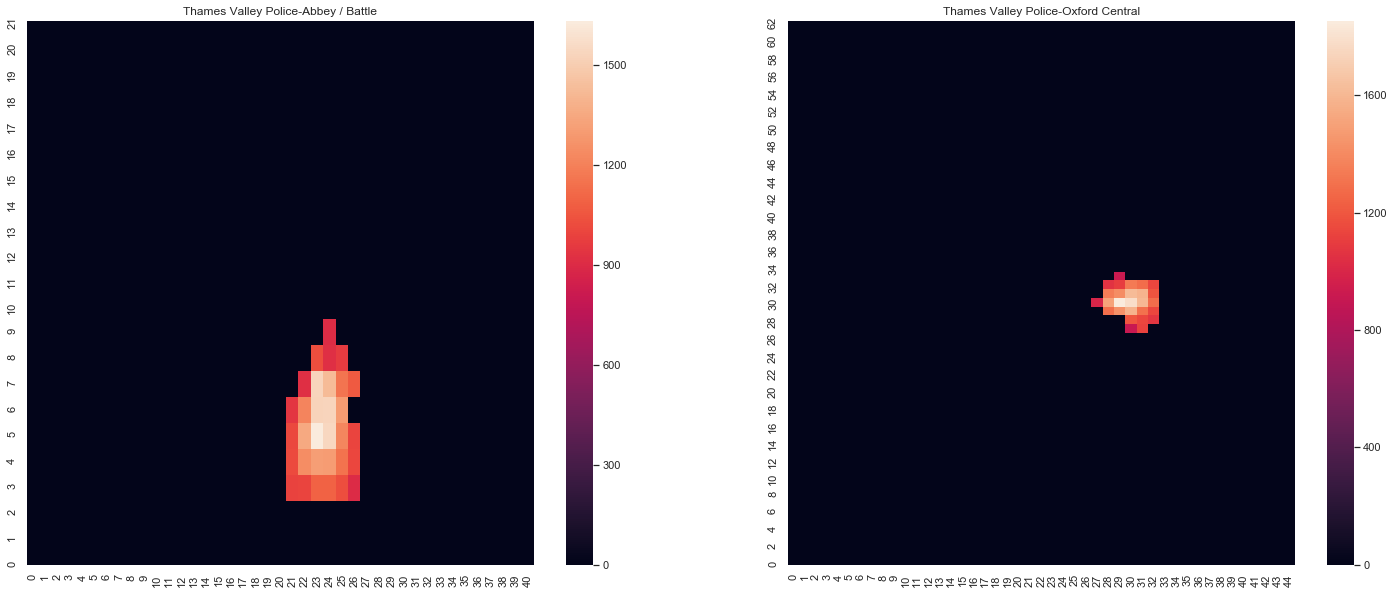

In [19]:
%matplotlib inline

import seaborn as sns; sns.set()

min_crimes = 900

fig, axes = plt.subplots(1, 2, figsize = (25,10))
nax = 0
for region in regions:
    nx = max([c[0] for c in region['crimes']])
    ny = max([c[1] for c in region['crimes']])
    cc1 = [c[4] for c in region['crimes']]
    
    data = np.reshape(cc1, (nx+1, ny+1 ))
    
    data = (data > min_crimes) * data
    
    ax = sns.heatmap(data, ax = axes[nax])
    ax.set_title(region['name'])
    nax += 1
    ax.invert_yaxis()

    im = ax.collections[0]
    region['rgba_values'] = im.cmap(im.norm(im.get_array()))

In [20]:
import copy

hotspot_maps = {}

for region in regions:
    #region = regions[0]
    crimes = pd.DataFrame(region['crimes'],columns = ['ix','iy','lat','lon','stat'])
    min_crimes = 900
    region['hotspots'] = crimes[crimes.stat > min_crimes]
    region['hotspots_rgbas'] = region['rgba_values'][crimes.stat > min_crimes]
    dlat = region['crimes_info'][0]
    dlon = region['crimes_info'][1]
    area_centroid_lat = (region['bbox']['sw'][0]+region['bbox']['ne'][0])/2
    area_centroid_lng = (region['bbox']['sw'][1]+region['bbox']['ne'][1])/2
    # get a map centered on the region
    hotspot_maps[region['name']] = folium.Map(width=400,height=400,location=[area_centroid_lat,area_centroid_lng],titles=region['name'], attr="attribution")
    #mymap = copy.copy(region['basemap'])
    hotspot_maps[region['name']].fit_bounds(bounds=[region['bbox']['sw'],region['bbox']['ne']])
    for element in zip(region['hotspots'].iterrows(),region['hotspots_rgbas']):
        hotspot = element[0]
        rgba = element[1]
        folium.Rectangle(
                        [[hotspot[1].lat-(dlat/2.0), hotspot[1].lon-(dlon/2.0)],[hotspot[1].lat+(dlat/2.0), hotspot[1].lon+(dlon/2.0)] ],
                        #popup=label,
                        #popup=None,
                        popup=(folium.Popup(f"{int(hotspot[1].stat)}")),
                        color=rgb2hex(rgba),
                        weight=2,
                        fill_opacity=0.6,
                        opacity=0.4,
                        fill=True,
                        ).add_to(hotspot_maps[region['name']])


In [21]:
regions[0]['hotspots'].head()

,ix,iy,lat,lon,stat
144,3,21,51.453568,-0.977185,989
145,3,22,51.453568,-0.975742,997
146,3,23,51.453568,-0.974298,1092
147,3,24,51.453568,-0.972855,1090
148,3,25,51.453568,-0.971412,1026


In [22]:
print(regions[0]['name'])
#hotspot_maps[regions[0]['name']]

Thames Valley Police-Abbey / Battle


![alt text](AbbeyBattle_Hotspots.png "Hotspot Data - Abbey Battle")

In [23]:
print(regions[1]['name'])
#hotspot_maps[regions[1]['name']]

Thames Valley Police-Oxford Central


![alt text](Oxford_Hotspots.png "Hotspot Data - Oxford Central")

In [24]:
pickle.dump( regions, open( "regions2.pkl", "wb" ) )

Now we have a collection of crime hotspots for 2 regions we can get the venues near to those hotspots.



### Foursquare Venue Data

## Data 2 - Venue Data

#### Foursquare venues

A coordinate can be supplied to the Foursquare API to obtain the venues within a specified radius. Each venue belongs to particular category and also, to a specific level of category. Out of the information per venue we only require the venue category.

The endpoint details are as follows. The *client id* and *client secret* are specific to the user and require a new user to sign up to Foursquare. *ll* is latitude longitude separated by a comma. Version  has been set here to "20180604" - see the Foursquare API site for more information. *MYRADIUS* will be set to the distance from the centroid of the cell from which to gather the venue information, typically set to a multiple of the cell size, e.g. cell size = 100 metres, MYRADIUS = 500 metres. *limit* can go up to 50 (per the latest version of the docs), we will use 50 in our study.

https://api.foursquare.com/v2/venues/search?client_id=&lt;clientid>&client_secret=&lt;clientsecret>&ll=40.7149555,-74.0153365&v=20180604&radius=MYRADIUS&limit=30


Foursquare API :
https://developer.foursquare.com/docs

#### Foursquare venue categories

A list of categories is also supplied by the Foursquare API.

These are at specified levels. For example, if a restaurant has a category of "Japanese Restaurant" and another one "Asian Restaurant" then they are both under the same general category of Food (Level 0) and Asian Restaurant (Level 1) but the venue information has given us a name that is deeper in the hierarchy (Japanese Restaurant is Level 2). We 'normalise' each venue category into levels. So for the two restaurants just mentioned we might look at Level 0, both Food. Level 1, both Asian Restaurant. Level 2, one is Japanese Restaurant and the other is Not-categorized (my terminology). Note that the level numbers I give here and use in the study are my own invention - Foursquare does not label their data in this way.

<pre>
Level 0 : Food
├── Level 1 : Afghan Restaurant
├── Level 1 : African Restaurant
│   └── Level 2 : Ethiopian Restaurant
├── ...
├── Level 1 : Asian Restaurant
│   ├── ...
│   ├── Level 2 : Japanese Restaurant
│   ├── ...
│   ├── Level 2 : Thai Restaurant
│       └── Level 3 : Som Tum Restaurant
│   └── ...
├── ...
</pre>

Page describing the Foursquare categories

https://developer.foursquare.com/docs/resources/categories

Page describing the API call

https://developer.foursquare.com/docs/api/venues/categories

API endpoint to receive JSON list of categories

https://api.foursquare.com/v2/venues/categories


In [25]:
# @hidden_cell
CLIENT_ID = 'VTEV5MX35CKCG2R50PIE4NTJT5TMKM0WNHBXGUSBCKA4W12Y' # your Foursquare ID
CLIENT_SECRET = 'BGIWCG2AV3CEBDTFOE355G4OGEEBYIDKBNMAYV0CHMVVDUN2' # your Foursquare Secret
VERSION = '20190606' # accept API versions up to this date
LIMIT = 100

In [26]:
class FourSquare:
    foursq = None
    cats = None
    
    def Load_Categories(self, filename):
        with open(filename) as json_file: #with open('foursq_categories.json') as json_file:
            foursq = json.load(json_file)  #    foursq = json.load(json_file)
            self.foursq = foursq['response']['categories']
            del foursq

    def AddCategory(self, df, category_name, n,level, parent_idx, icon_url):
        df.loc[n] = [n, category_name, level, parent_idx, icon_url]

    def Traverse(self, df, cats, n, L, p):
        for cat in cats:
            n += 1
            icon_url = cat['icon']['prefix']+"<SIZE>"+cat['icon']['suffix']
            self.AddCategory(df, cat['name'],n,L+1,p, icon_url)
            #parent = n
            n = self.Traverse(df, cat['categories'], n,L+1,n)
        return n

    def Build_Categories(self):
        columns = ['Index','Category','Level','Parent_idx','Icon_URL']

        df = pd.DataFrame(columns=columns)

        df = df.astype(dtype= {"Index":"int64",
                "Category":"object",
                "Level":"int64",
                "Parent_idx":"int64",
                "Icon_URL":"object",
                      })

        self.Traverse(df,self.foursq,0,0,0)
        
        self.cats = df
        
        #return df
    def GetCategory(self,cat_tree, category, level):
        #print("----GetCategory----")
        row = cat_tree[cat_tree.Category == category]
        this_level = row.iloc[0]['Level']
        if this_level > level:
            for i in range(this_level - level):
                row = cat_tree.loc[cat_tree['Index'] == row.iloc[0]['Parent_idx'] ]
    
        if level > this_level:
            pass
        return row.iloc[0]['Category']

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, end=':')
        print('\r', end='')
        
        #print(f"name={name},lat={lat},lon={lon}")
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        #print(f"url={url}")
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    nearby_venues.drop_duplicates(subset=['Neighborhood', 'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'], inplace=True)
    print()
    return(nearby_venues)

In [28]:
LIMIT=100
RADIUS = 300

for region in regions:
    print(f"{region['name']}")
    #print(region['hotspots'])
    names = [ e[0] for e in enumerate(region['hotspots'].index)]
    latitudes = [ e for e in region['hotspots'].lat ]
    longitudes = [ e for e in region['hotspots'].lon ]
    region['venues'] = getNearbyVenues(names = names,
                                   latitudes = latitudes,
                                   longitudes = longitudes,
                                   radius = RADIUS,
                                   limit = LIMIT
                                  )
    print()
    
print("..finished")

for region in regions:
    print(f"{region['force']}:{region['hood']}")
    venues = region['venues']
    print(venues.shape)
    print(venues.sample(4))
    print()
    print('There are {} unique categories in this region.'.format(len(venues['Venue Category'].unique())))
    print("="*40)


foursq_file = 'foursq.pkl'
fq = FourSquare()
if os.path.isfile(foursq_file):
    with open(foursq_file,"rb") as f:
        fq = pickle.load(f)
else:
    
    fq.Load_Categories('foursq_categories.json')
    fq.Build_Categories()
    print(f"There are {len(fq.cats)} categories")
    fq.cats.sample(5)
    with open(foursq_file,"wb") as f:
        pickle.dump(fq,f)


Thames Valley Police-Abbey / Battle
31:

Thames Valley Police-Oxford Central
26:

..finished
Thames Valley Police:Abbey / Battle
(1392, 7)
     Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
71              3              51.453568               -0.972855   
461            11              51.454467               -0.969969   
982            22              51.456266               -0.971412   
885            20              51.456266               -0.974298   

                  Venue  Venue Latitude  Venue Longitude    Venue Category  
71      BrewDog Reading       51.453519        -0.974274          Beer Bar  
461   The Tasting House       51.455207        -0.973087          Wine Bar  
982    Workhouse Coffee       51.455208        -0.970117       Coffee Shop  
885  German Doner Kebab       51.456599        -0.975200  Doner Restaurant  

There are 64 unique categories in this region.
Thames Valley Police:Oxford Central
(1553, 7)
     Neighborhood  Neighborhood Latitude 

In [29]:
#lets get Level Categories for the venues
if True:#if not 'grouped' in regions[0].keys():
    MAX_LEVEL = 4
    for region in regions:
        #region = regions[0]
        venues = region['venues']
        region['grouped'] = {}
        
        print(region['name'])
        
        for level in range(1,MAX_LEVEL+1):
            print(f"level={level}")
            level_cats = venues['Venue Category'].apply(lambda x : fq.GetCategory(fq.cats,x, level))
            
            region_onehot = pd.get_dummies(level_cats, prefix="", prefix_sep="")
        
            # add neighborhood column back to dataframe
            region_onehot['Neighborhood'] = venues['Neighborhood']
        
            # move neighborhood column to the first column
            fixed_columns = [region_onehot.columns[-1]] + list(region_onehot.columns[:-1])
            region_onehot = region_onehot[fixed_columns]
        
            #region_onehot.sample(10)
            #region_onehot.shape
            region_grouped = region_onehot.groupby('Neighborhood').mean().reset_index()
    
            region['grouped'][level] = region_grouped

Thames Valley Police-Abbey / Battle
level=1
level=2
level=3
level=4
Thames Valley Police-Oxford Central
level=1
level=2
level=3
level=4


## METHODOLOGY

Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

* #### Given the boundary outlining an area we gridify that area into equal sized square cells

This is described above.

* For each cell get the number of crimes within a specified search radius

Here all of the crimes within the radius were included. Each crime belongs to a particular type of crime category. The full list is as follows:

from: https://data.police.uk/api/crime-categories?date=2019-12

url | name
--- | ---
anti-social-behaviour | Anti-social behaviour
bicycle-theft | Bicycle theft
burglary | Burglary
criminal-damage-arson | Criminal damage and arson
drugs | Drugs
other-theft | Other theft
possession-of-weapons | Possession of weapons
public-order | Public order
robbery | Robbery
shoplifting | Shoplifting
theft-from-the-person | Theft from the person
vehicle-crime | Vehicle crime
violent-crime | Violence and sexual offences
other-crime | Other crime

Some crime categories could be removed in the study to reflect the particular questions being asked. If one were to be analysing theft then one might only include 'Bicycle theft', 'Other theft',' Shoplifting', 'Theft from the person' and exclude the rest. This can be achieved by filtering the crime data on 'category'.

* #### For each cell find all venues from FourSquare within a specific search radius.

Example

<table border="1" class="dataframe"> <thead><tr style="text-align: right;">  <th></th>  <th>Cell</th>  <th>Cell Latitude</th>  <th>Cell Longitude</th>  <th>Venue</th>  <th>Venue Latitude</th>  <th>Venue Longitude</th>  <th>Venue Category</th></tr> </thead> <tbody><tr>  <th>124</th>  <td>2</td>  <td>51.454018</td>  <td>-0.972134</td>  <td>Market Place</td>  <td>51.455566</td>  <td>-0.969469</td>  <td>Plaza</td></tr><tr>  <th>129</th>  <td>2</td>  <td>51.454018</td>  <td>-0.972134</td>  <td>Greggs</td>  <td>51.455459</td>  <td>-0.969436</td>  <td>Bakery</td></tr><tr>  <th>80</th>  <td>2</td>  <td>51.454018</td>  <td>-0.972134</td>  <td>Côte Brasserie</td>  <td>51.453729</td>  <td>-0.969215</td>  <td>French Restaurant</td></tr><tr>  <th>126</th>  <td>2</td>  <td>51.454018</td>  <td>-0.972134</td>  <td>Royal Tandoori</td>  <td>51.454898</td>  <td>-0.968959</td>  <td>Indian Restaurant</td></tr><tr>  <th>103</th>  <td>2</td>  <td>51.454018</td>  <td>-0.972134</td>  <td>The Botanist</td>  <td>51.455107</td>  <td>-0.969595</td><td>English Restaurant</td></tr> </tbody></table>


* #### Transform each cell's venues into levels, i.e. a level 1 list, then a level 2 list and so on.

For instance, 'Plaza' in the list of Four Square categories is under 'Outdoors & Recreation'.

```
Outdoors & Recreation
|-- Plaza
```
    
 Outdoors.. is assigned a level 1 designation as it is the topmost layer. Plaza is then assigned level 2.

```
1 Outdoors & Recreation
|-- 2 Plaza
1 Food
|-- 2 Bakery
|-- 2 French Restaurant
|   |-- 3 Burgundian Restaurant
|-- 2 Indian Restaurant
|   |-- 3 Andhra Restaurant
|   |-- 3 Awadhi Restaurant
|-- 2 English Restaurant
```

* #### For each level One-hot encode those venue lists

The one-hot encoding calculates the frequencies for those venue categories.

Given the following venues and level 1 we would have the following one-hot table (these are truncated for display purposes).

__Venues for cell__

Plaza, Bakery, Bakery, French Restaurant, Burgundian Restaurant, English Restaurant

__One-Hot Table Level 1__

Arts & Entertainment | College & University | Events | Food | Nightlife Spot | Outdoors & Recreation | Professional & Other Places | Residence | Shop & Service | Travel & Transport
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
0.0 | 0.0 | 0.0 | 0.8333 | 0.0 | 0.1666 | 0.0 | 0.0 | 0.0 | 0.0 |

__One-Hot Table Level 2__

Amphitheater | Aquarium | ... | Plaza | Bakery | French Restaurant | English Restaurant
--- | --- | --- | --- | --- | --- | ---
0.0 | 0.0 | ... | 0.1666 | 0.3333 | 0.3333 | 0.1666

* #### Use k-means to categorise the venue lists with increasing number of clusters.

```
 for level in range(1,MAX_LEVEL+1):
    region_grouped_clustering = region['grouped'][level]
                                .drop('Neighborhood', 1)
           
    Sum_of_squared_distances = []    
        K = range(1,15)
        for kclusters in K:
            kmeans = KMeans(n_clusters=kclusters, random_state=0)
                      .fit(region_grouped_clustering)
            Sum_of_squared_distances.append(kmeans.inertia_)
```

* #### Find the optimal number of clusters for K means by using the elbow method and 2nd differences

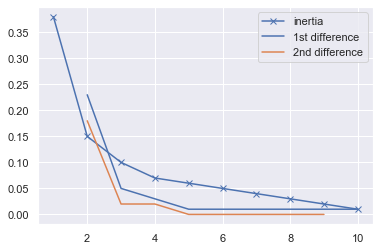

In [30]:
# Optimal K example

K = np.array([1,2,3,4,5,6,7,8,9,10])
inertia = np.array([0.38, 0.15, 0.10, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01])

plt.plot( K, inertia, 'bx-', label='inertia')
plt.plot( K[1:], -np.diff(inertia), label='1st difference')
plt.plot( K[1:-1], -np.diff(-np.diff(inertia)), label='2nd difference')
_ = plt.legend()

We take the first difference (the delta) and then take the difference of the deltas (the gamma or convexity).

In the above the greatest 2nd difference is for $K = 2$. This becomes our optimal number of clusters, 'optimal K'.

Then apply that particular K-means to obtain the cluster corresponding to the cells.

level 1 optimal_k=2


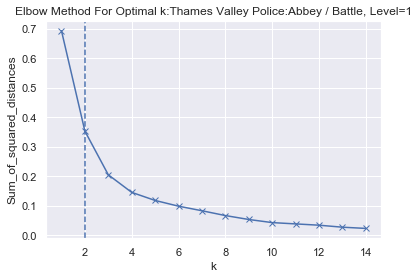

level 2 optimal_k=3


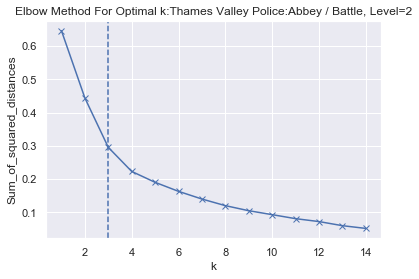

level 3 optimal_k=2


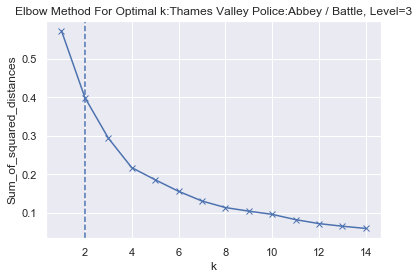

level 4 optimal_k=2


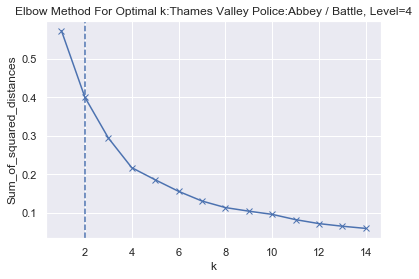

level 1 optimal_k=3


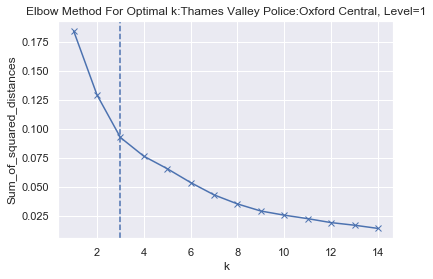

level 2 optimal_k=3


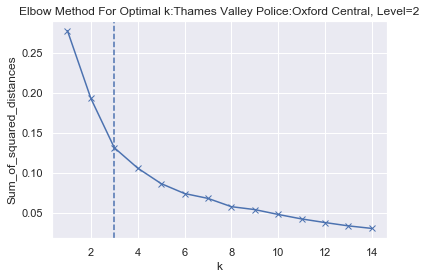

level 3 optimal_k=2


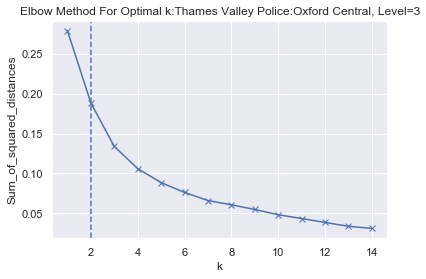

level 4 optimal_k=2


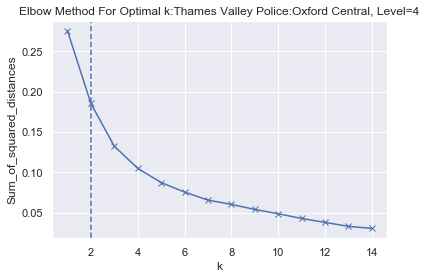

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


def kmeans_optimal_elbow(criterion):
    n = len(criterion)

    delta1 = -np.diff(criterion)
    delta2 = -np.diff(delta1)

    delta1 = np.concatenate(([0,0], delta1), axis=0)[-n:]
    delta2 = np.concatenate(([0,0], delta2), axis=0)[-n:]

    '''
    strength = delta2 - delta1
    strength = strength * (strength >0)*1.0
    k = np.array([k+1 for k in range(n)])
    rel_strength = strength / k
    max_k = rel_strength.argmax()-1
    '''
    k = np.array([k+1 for k in range(n)])
    max_k = delta2.argmax()-1
    return k[max_k]

# ## 4. Cluster Neighbourhoods

num_top_venues = 5
MAX_LEVEL = 4
for region in regions:
    region_name = f"{region['force']}:{region['hood']}"
    region_data = region['hotspots'][['lat','lon']].reset_index()
    region_data['Neighborhood'] = region_data.index
    
    region['clusters'] = {}
    region['kmeans'] = {}
    
    for level in range(1,MAX_LEVEL+1):
        region_grouped_clustering = region['grouped'][level].drop('Neighborhood', 1)
           
        Sum_of_squared_distances = []    
        # the number of samples should be greater than or equal to the number of clusters
        K = range(1,min(15, len(region_grouped_clustering)))
        for kclusters in K:
            kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(region_grouped_clustering)
            Sum_of_squared_distances.append(kmeans.inertia_)
            
        criterion = Sum_of_squared_distances
        optimal_k = kmeans_optimal_elbow(criterion)
        print(f"level {level} optimal_k={optimal_k}")
        
        get_ipython().run_line_magic('matplotlib', 'inline')
            
        plt.plot(K, criterion, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title(f"Elbow Method For Optimal k:{region_name}, Level={level}")
        plt.axvline(x=optimal_k, ymin=0.0, ymax=1,linestyle='--')
        plt.show()
        
        # get the cluster info
        kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(region_grouped_clustering)
        region['kmeans'][level] = kmeans
        indicators = ['st', 'nd', 'rd']
    
        # create columns according to number of top venues
        columns = ['Neighborhood']
        for ind in np.arange(num_top_venues):
            try:
                columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
            except:
                columns.append('{}th Most Common Venue'.format(ind+1))
    
        # create a new dataframe
        neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
        neighborhoods_venues_sorted['Neighborhood'] = region['grouped'][level]['Neighborhood']
    
        for ind in np.arange(region['grouped'][level].shape[0]):
            try:
                res = return_most_common_venues(region['grouped'][level].iloc[ind, :], num_top_venues)
                neighborhoods_venues_sorted.iloc[ind, 1:] = res
            except:
                neighborhoods_venues_sorted.iloc[ind, 2:] = res

            if 'Cluster Labels' in neighborhoods_venues_sorted.columns:
                neighborhoods_venues_sorted.drop(['Cluster Labels'],inplace=True,axis=1)
            neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
        
        region_merged = region_data
        
        # merge region_grouped with region_data to add latitude/longitude for each neighborhood
        region_merged = region_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
        region['clusters'][level] = region_merged


In [32]:
pickle.dump(regions, open("regions3.pkl","wb"))

## RESULTS

### FourSquare Venues & K-Means

In [33]:
from IPython.display import display, Markdown, Latex

def ShowResults(region_idx, level):
    txt = regions[region_idx]['clusters'][level] \
        .drop(['Neighborhood','lat','lon', 'index'],axis=1)
    txt = txt \
        .drop_duplicates() \
        .astype({'Cluster Labels':'int32'}) \
        .sort_values(by=['Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']) \
        .to_html(index=False) \
        .replace("\n","")
    display(Markdown(f"#### **Region {region_idx}, Level {level}**"))
    display(Markdown(txt))

In [34]:
_ = ShowResults(0,1)
_ = ShowResults(1,1)

#### **Region 0, Level 1**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Food</td>      <td>Nightlife Spot</td>      <td>Shop &amp; Service</td>      <td>Travel &amp; Transport</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Shop &amp; Service</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Outdoors &amp; Recreation</td>      <td>Travel &amp; Transport</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Travel &amp; Transport</td>      <td>Nightlife Spot</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>1</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>1</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Travel &amp; Transport</td>      <td>Nightlife Spot</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>1</td>      <td>Food</td>      <td>Travel &amp; Transport</td>      <td>Nightlife Spot</td>      <td>Shop &amp; Service</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>1</td>      <td>Food</td>      <td>Travel &amp; Transport</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Outdoors &amp; Recreation</td>    </tr>  </tbody></table>

#### **Region 1, Level 1**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Food</td>      <td>Nightlife Spot</td>      <td>Shop &amp; Service</td>      <td>Outdoors &amp; Recreation</td>      <td>Arts &amp; Entertainment</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Arts &amp; Entertainment</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Arts &amp; Entertainment</td>      <td>Travel &amp; Transport</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Outdoors &amp; Recreation</td>      <td>Arts &amp; Entertainment</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Arts &amp; Entertainment</td>    </tr>    <tr>      <td>0</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>1</td>      <td>Food</td>      <td>Nightlife Spot</td>      <td>Shop &amp; Service</td>      <td>Travel &amp; Transport</td>      <td>Arts &amp; Entertainment</td>    </tr>    <tr>      <td>1</td>      <td>Food</td>      <td>Nightlife Spot</td>      <td>Shop &amp; Service</td>      <td>Travel &amp; Transport</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>1</td>      <td>Food</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Shop &amp; Service</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>2</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Arts &amp; Entertainment</td>      <td>Outdoors &amp; Recreation</td>    </tr>    <tr>      <td>2</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Arts &amp; Entertainment</td>      <td>Travel &amp; Transport</td>    </tr>    <tr>      <td>2</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Outdoors &amp; Recreation</td>      <td>Arts &amp; Entertainment</td>    </tr>    <tr>      <td>2</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Arts &amp; Entertainment</td>    </tr>    <tr>      <td>2</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Nightlife Spot</td>      <td>Travel &amp; Transport</td>      <td>Professional &amp; Other Places</td>    </tr>    <tr>      <td>2</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Travel &amp; Transport</td>      <td>Arts &amp; Entertainment</td>      <td>Professional &amp; Other Places</td>    </tr>    <tr>      <td>2</td>      <td>Food</td>      <td>Shop &amp; Service</td>      <td>Travel &amp; Transport</td>      <td>Nightlife Spot</td>      <td>Arts &amp; Entertainment</td>    </tr>  </tbody></table>

This is an interesting set of results. For both regions the primary influence are Food venues with Shops Travel and Nightlife venues also having a large influence.

By going to level 2 venue categories we may gain an insight into the kinds of Food, Shops etc venues.

In [35]:
_ = ShowResults(0,2)
_ = ShowResults(1,2)

#### **Region 0, Level 2**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Asian Restaurant</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Italian Restaurant</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Coffee Shop</td>      <td>Italian Restaurant</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Burger Joint</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Italian Restaurant</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Dessert Shop</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Train Station</td>    </tr>    <tr>      <td>1</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Train Station</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Bar</td>      <td>Train Station</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>      <td>Coffee Shop</td>    </tr>    <tr>      <td>1</td>      <td>Bar</td>      <td>Train Station</td>      <td>Coffee Shop</td>      <td>Food &amp; Drink Shop</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Train Station</td>      <td>Asian Restaurant</td>      <td>Hotel</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Train Station</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Train Station</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>      <td>Coffee Shop</td>    </tr>    <tr>      <td>1</td>      <td>Train Station</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Food &amp; Drink Shop</td>    </tr>    <tr>      <td>2</td>      <td>Asian Restaurant</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Coffee Shop</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>2</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Sandwich Place</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Sandwich Place</td>      <td>Food &amp; Drink Shop</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Sandwich Place</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Asian Restaurant</td>      <td>Coffee Shop</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Asian Restaurant</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Asian Restaurant</td>      <td>Department Store</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Italian Restaurant</td>      <td>Asian Restaurant</td>    </tr>  </tbody></table>

#### **Region 1, Level 2**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Asian Restaurant</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Bakery</td>      <td>American Restaurant</td>      <td>Coffee Shop</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Café</td>      <td>Bakery</td>      <td>Clothing Store</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Hotel</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Coffee Shop</td>      <td>Nightclub</td>      <td>Café</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Dessert Shop</td>      <td>Café</td>      <td>Bakery</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Nightclub</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>0</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Nightclub</td>      <td>Hotel</td>      <td>Indian Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Bar</td>      <td>Burger Joint</td>      <td>Coffee Shop</td>      <td>Restaurant</td>      <td>Hotel</td>    </tr>    <tr>      <td>1</td>      <td>Burger Joint</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>      <td>Restaurant</td>      <td>Coffee Shop</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Hotel</td>      <td>Sandwich Place</td>      <td>Burger Joint</td>      <td>Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Hotel</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>      <td>Café</td>      <td>Restaurant</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Coffee Shop</td>      <td>Dessert Shop</td>      <td>Café</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Café</td>      <td>Bookstore</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Café</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Asian Restaurant</td>      <td>Food &amp; Drink Shop</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Asian Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>2</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Dessert Shop</td>      <td>Food &amp; Drink Shop</td>      <td>Café</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Bar</td>      <td>Café</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Café</td>      <td>Bar</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Café</td>      <td>Sandwich Place</td>      <td>Bar</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Café</td>      <td>Bookstore</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Café</td>      <td>Dessert Shop</td>      <td>Art Gallery</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Dessert Shop</td>      <td>Asian Restaurant</td>      <td>Café</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Bookstore</td>      <td>Asian Restaurant</td>      <td>Dessert Shop</td>      <td>Food &amp; Drink Shop</td>    </tr>    <tr>      <td>2</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Bar</td>      <td>Dessert Shop</td>      <td>Art Gallery</td>    </tr>  </tbody></table>

For both regions Bars look to be the primary influences with important but secondary being Coffee Shops and Asian Restaurants.

In [36]:
_ = ShowResults(0,3)
_ = ShowResults(1,3)

#### **Region 0, Level 3**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Clothing Store</td>      <td>Coffee Shop</td>      <td>Italian Restaurant</td>      <td>Asian Restaurant</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Japanese Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Italian Restaurant</td>      <td>Department Store</td>      <td>Cocktail Bar</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Italian Restaurant</td>      <td>English Restaurant</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Burger Joint</td>      <td>Clothing Store</td>      <td>Japanese Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Burger Joint</td>      <td>Cocktail Bar</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Italian Restaurant</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>English Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Asian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Bar</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Burger Joint</td>      <td>Japanese Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Indian Restaurant</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Burger Joint</td>      <td>Pub</td>      <td>Asian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Italian Restaurant</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Indian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Italian Restaurant</td>      <td>English Restaurant</td>      <td>Dessert Shop</td>      <td>Doner Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Italian Restaurant</td>      <td>Burger Joint</td>      <td>Cocktail Bar</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Italian Restaurant</td>      <td>Dessert Shop</td>      <td>Café</td>    </tr>    <tr>      <td>1</td>      <td>Clothing Store</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Pub</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Clothing Store</td>      <td>Sandwich Place</td>      <td>Pub</td>      <td>Japanese Restaurant</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Sandwich Place</td>      <td>Italian Restaurant</td>      <td>Clothing Store</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Platform</td>      <td>Bar</td>      <td>Sandwich Place</td>      <td>English Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Platform</td>      <td>Pub</td>      <td>Sandwich Place</td>      <td>Clothing Store</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Sandwich Place</td>      <td>Bar</td>      <td>Platform</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Japanese Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Pub</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Sandwich Place</td>      <td>Pub</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Bar</td>      <td>Pub</td>    </tr>    <tr>      <td>1</td>      <td>Pub</td>      <td>Clothing Store</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Pub</td>      <td>Clothing Store</td>      <td>Sandwich Place</td>      <td>Bar</td>      <td>Asian Restaurant</td>    </tr>  </tbody></table>

#### **Region 1, Level 3**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bookstore</td>      <td>Thai Restaurant</td>      <td>Café</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Hotel</td>      <td>Sandwich Place</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Art Gallery</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Pub</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Bookstore</td>      <td>Art Gallery</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Art Gallery</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Bookstore</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Hotel</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Bookstore</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Café</td>      <td>Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Café</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Thai Restaurant</td>      <td>Bookstore</td>      <td>Café</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Nightclub</td>      <td>Pub</td>      <td>Indian Restaurant</td>      <td>Hotel</td>      <td>Café</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Bakery</td>      <td>American Restaurant</td>      <td>Sandwich Place</td>      <td>Indian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Café</td>      <td>Bakery</td>      <td>American Restaurant</td>      <td>Indian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Café</td>      <td>Bakery</td>      <td>American Restaurant</td>      <td>Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Art Gallery</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Coffee Shop</td>      <td>Thai Restaurant</td>      <td>Bakery</td>      <td>Café</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Coffee Shop</td>      <td>Thai Restaurant</td>      <td>Café</td>      <td>Nightclub</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Nightclub</td>      <td>Coffee Shop</td>      <td>American Restaurant</td>      <td>Japanese Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Burger Joint</td>      <td>Sandwich Place</td>      <td>Pizza Place</td>      <td>Restaurant</td>      <td>Hotel</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Pizza Place</td>      <td>Sandwich Place</td>      <td>Hotel</td>      <td>Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Pizza Place</td>      <td>Hotel</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Pub</td>      <td>Pizza Place</td>      <td>Burger Joint</td>      <td>Coffee Shop</td>      <td>Hotel</td>    </tr>  </tbody></table>

At level 3 Coffee Shop and Pub are the primary influences.

In [37]:
_ = ShowResults(0,4)
_ = ShowResults(1,4)

#### **Region 0, Level 4**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Italian Restaurant</td>      <td>Bar</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Italian Restaurant</td>      <td>Café</td>      <td>Clothing Store</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Asian Restaurant</td>      <td>Italian Restaurant</td>      <td>English Restaurant</td>      <td>Dessert Shop</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Pub</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Burger Joint</td>      <td>English Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Burger Joint</td>      <td>Sushi Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Asian Restaurant</td>      <td>Clothing Store</td>      <td>Pub</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Clothing Store</td>      <td>Cocktail Bar</td>      <td>Asian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Bakery</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Burger Joint</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Bar</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Asian Restaurant</td>      <td>Sushi Restaurant</td>      <td>Burger Joint</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Burger Joint</td>      <td>Sushi Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Department Store</td>      <td>Sushi Restaurant</td>      <td>Indian Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Italian Restaurant</td>      <td>Department Store</td>      <td>Sushi Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Bar</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Italian Restaurant</td>      <td>English Restaurant</td>      <td>Dessert Shop</td>      <td>Doner Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Burger Joint</td>      <td>Italian Restaurant</td>      <td>Department Store</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Italian Restaurant</td>      <td>Dessert Shop</td>      <td>Pie Shop</td>    </tr>    <tr>      <td>1</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Sandwich Place</td>      <td>Asian Restaurant</td>      <td>Bar</td>    </tr>    <tr>      <td>1</td>      <td>Clothing Store</td>      <td>Sandwich Place</td>      <td>Pub</td>      <td>Sushi Restaurant</td>      <td>Coffee Shop</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Bakery</td>      <td>Pub</td>      <td>Clothing Store</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Clothing Store</td>      <td>Pub</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Platform</td>      <td>Pub</td>      <td>Sandwich Place</td>      <td>Bar</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Platform</td>      <td>Sandwich Place</td>      <td>Bar</td>      <td>Italian Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Pub</td>      <td>Clothing Store</td>      <td>Bar</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Pub</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Sandwich Place</td>      <td>Pub</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Bar</td>      <td>Sushi Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Platform</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Bar</td>      <td>Pub</td>    </tr>    <tr>      <td>1</td>      <td>Pub</td>      <td>Clothing Store</td>      <td>Bar</td>      <td>Sandwich Place</td>      <td>Asian Restaurant</td>    </tr>  </tbody></table>

#### **Region 1, Level 4**

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Cluster Labels</th>      <th>1st Most Common Venue</th>      <th>2nd Most Common Venue</th>      <th>3rd Most Common Venue</th>      <th>4th Most Common Venue</th>      <th>5th Most Common Venue</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Art Gallery</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Sandwich Place</td>      <td>Hotel</td>      <td>Pizza Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Hotel</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Café</td>      <td>Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Pub</td>      <td>Thai Restaurant</td>      <td>Sandwich Place</td>      <td>Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Thai Restaurant</td>      <td>Café</td>      <td>Restaurant</td>    </tr>    <tr>      <td>0</td>      <td>Coffee Shop</td>      <td>Thai Restaurant</td>      <td>Bookstore</td>      <td>Café</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Bakery</td>      <td>Sandwich Place</td>      <td>Indian Restaurant</td>      <td>Coffee Shop</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Café</td>      <td>Bakery</td>      <td>American Restaurant</td>      <td>Clothing Store</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Café</td>      <td>Bakery</td>      <td>Roof Deck</td>      <td>Hotel</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Thai Restaurant</td>      <td>Art Gallery</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Coffee Shop</td>      <td>Thai Restaurant</td>      <td>Bakery</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Coffee Shop</td>      <td>Thai Restaurant</td>      <td>Café</td>      <td>Nightclub</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Nightclub</td>      <td>Coffee Shop</td>      <td>American Restaurant</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>0</td>      <td>Pub</td>      <td>Nightclub</td>      <td>Hotel</td>      <td>Indian Restaurant</td>      <td>Thai Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Café</td>      <td>Hotel</td>      <td>Pizza Place</td>      <td>Sandwich Place</td>    </tr>    <tr>      <td>1</td>      <td>Coffee Shop</td>      <td>Sandwich Place</td>      <td>Pizza Place</td>      <td>Hotel</td>      <td>Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Pizza Place</td>      <td>Burger Joint</td>      <td>Sandwich Place</td>      <td>Coffee Shop</td>      <td>Restaurant</td>    </tr>    <tr>      <td>1</td>      <td>Pub</td>      <td>Restaurant</td>      <td>Pizza Place</td>      <td>Burger Joint</td>      <td>Hotel</td>    </tr>  </tbody></table>

At level 4 Coffee Shop and Pub are the primary influences.

## DISCUSSION
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

* While Food related venues are the primary influence at level 1, at higher levels it loses out to such venues as Coffee SHops and Bars.

* The one-hot encoding looks at the relative frequencies of venues in the area surrounding the cell but  this does not take into account the numbers of venues. One cell may have 20 venues nearby with another one having only 5 but their relative frequencies could be the same. To this algorithm there would seem to be no difference.

* The higher levels (3 and 4) do not give much more information since the venue categories across both levels are almost the same. This is due to the original categorisation by FourSquare but is not necessarily a problem since not using level 4 can make the investigation quicker.

* Could include the non-hotspots to see if they can be predicted. We have only covered the venue types for crime hotspots. It would make an interesting project to see if there is a way to include non-hotspot information to predict crime hotspots.

* To determine crime hotspots we used a simple total number of crimes as the statistic. Another method is to use an area based relative statistic such as Getis-Ord which looks at the local totals vs the normally distributed totals across the area.

* We have used the crimes across all of the crime categories but perhaps there is a subset that could be more useful for crime hotspot prediction.
    
* We used a cell size of 100 metres with a search radius of 300 metres for both crime search. What about 50m, or 100m?

* A naive but effective way to determine crime hotspots would be to merely look at the number of venues near to a cell. 

* An extension of the naive method just described could be to take the general kind of venue into account. A large number of Art Galleries is unlikely to influence the crime rate and so could be excluded. However, in reality those galleries woudl be accompanied by support businesses that intend to grab some footfall.

## CONCLUSION

There is a lot of useful data collected for this project even if the kmeans approach did not yield definitive answers.